https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a

In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader
import torch
import torch.nn as nn # layer들을 호출하기 위해서
import numpy as np
import torch.optim as optim # optimization method를 사용하기 위해서
import torch.nn.init as init # weight initialization 해주기 위해서
from tqdm import tqdm

import os
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
from parallel import DataParallelModel,DataParallelCriterion
# %matplotlib inline

from efficientnet_pytorch import EfficientNet

In [2]:
batch_size = 128
num_workers = 2 * torch.cuda.device_count()
print(num_workers)
print(os.cpu_count())

14
48


In [3]:
train_set = ImageFolder(root='./stanford/train')
test_set = ImageFolder(root='./stanford/test')

n_class = len(train_set.classes)


dataset_size = len(train_set)
val_pct = 0.2
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size
test_size = len(test_set)

train_size, val_size, test_size

(9600, 2400, 8580)

In [4]:
train_ds, val_ds = random_split(train_set, [train_size, val_size])
len(train_ds), len(val_ds)

(9600, 2400)

In [5]:
# Image Transform을 지정합니다.
train_transform = transforms.Compose([
#        transforms.Resize((128, 128)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

val_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
#     transforms.Resize((128, 128)), 
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [6]:
# 이미지 폴더로부터 데이터를 로드합니다.
class Dataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label
        
        
train_dataset = Dataset(train_ds, train_transform)
val_dataset = Dataset(val_ds, val_transform)
test_dataset = Dataset(test_set, test_transform)

In [7]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=num_workers, pin_memory=True)

In [8]:
# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화

# def show_batch(dl):
#     for img, lb in dl:
#         fig, ax = plt.subplots(figsize=(16, 8))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
#         break
        
# show_batch(train_loader)

In [9]:
images, classes = next(iter(train_loader))

images.shape, classes.shape

(torch.Size([128, 3, 256, 256]), torch.Size([128]))

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
class ModelBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [12]:
class PretrainedEfficientNet_V2(ModelBase):
    def __init__(self):
        super().__init__()
        
        self.network = EfficientNet.from_pretrained('efficientnet-b4')
#         Replace last layer
        num_ftrs = self.network._fc.in_features
        self.network._fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_class),
            nn.LogSoftmax(dim=1)
        )
        self.network = nn.DataParallel(self.network,device_ids=[0,1,2,3,4])
#         self.network = DataParallelModel(self.network)
        
    def forward(self, xb):
        return self.network(xb)

In [13]:
model = PretrainedEfficientNet_V2()
model

Loaded pretrained weights for efficientnet-b4


PretrainedEfficientNet_V2(
  (network): DataParallel(
    (module): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            48, 12, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            12, 48, kernel_size=(1, 1), stride=(1, 1)
            (stat

In [14]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

    
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [15]:
# getting default device
device = torch.device('cuda')
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)


# moving model to gpu
to_device(model, device);

cuda


In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    #초기 learing rate에서 1cycle annealing하는 scheduler이다. 1주기 전략은 
    #초기 learning rate에서 최대 learning rate까지 올라간 후 초기 learning rate보다 훨씬 낮은 learning rate로 annealing한다. 
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [17]:
evaluate(model, val_dl) 

{'val_loss': 4.785293102264404, 'val_acc': 0.006119791883975267}

In [18]:
opt_func = torch.optim.SGD
num_epoch = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [19]:
history = fit_one_cycle(num_epoch, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

100%|██████████| 75/75 [00:59<00:00,  1.26it/s]


Epoch [0] : train_loss: 4.7888, val_loss: 4.7784, val_acc: 0.0074


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [1] : train_loss: 4.7782, val_loss: 4.7607, val_acc: 0.0180


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [2] : train_loss: 4.7527, val_loss: 4.7265, val_acc: 0.0733


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [3] : train_loss: 4.6997, val_loss: 4.6580, val_acc: 0.2608


100%|██████████| 75/75 [00:54<00:00,  1.39it/s]


Epoch [4] : train_loss: 4.5822, val_loss: 4.4775, val_acc: 0.4983


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [5] : train_loss: 4.2391, val_loss: 3.7519, val_acc: 0.5560


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


Epoch [6] : train_loss: 3.3669, val_loss: 2.4584, val_acc: 0.6414


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [7] : train_loss: 2.3261, val_loss: 1.5669, val_acc: 0.7667


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


Epoch [8] : train_loss: 1.6512, val_loss: 1.0954, val_acc: 0.8039


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


Epoch [9] : train_loss: 1.3030, val_loss: 0.8508, val_acc: 0.8283


100%|██████████| 75/75 [00:54<00:00,  1.39it/s]


Epoch [10] : train_loss: 1.0812, val_loss: 0.6797, val_acc: 0.8413


100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


Epoch [11] : train_loss: 0.9388, val_loss: 0.5920, val_acc: 0.8462


100%|██████████| 75/75 [00:54<00:00,  1.36it/s]


Epoch [12] : train_loss: 0.8410, val_loss: 0.5225, val_acc: 0.8596


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [13] : train_loss: 0.7620, val_loss: 0.4816, val_acc: 0.8576


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [14] : train_loss: 0.6918, val_loss: 0.4399, val_acc: 0.8690


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [15] : train_loss: 0.6370, val_loss: 0.4156, val_acc: 0.8732


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [16] : train_loss: 0.5895, val_loss: 0.4020, val_acc: 0.8796


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


Epoch [17] : train_loss: 0.5590, val_loss: 0.3908, val_acc: 0.8822


100%|██████████| 75/75 [00:56<00:00,  1.34it/s]


Epoch [18] : train_loss: 0.5165, val_loss: 0.3866, val_acc: 0.8780


100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


Epoch [19] : train_loss: 0.4820, val_loss: 0.3748, val_acc: 0.8846


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [20] : train_loss: 0.4509, val_loss: 0.3754, val_acc: 0.8841


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [21] : train_loss: 0.4307, val_loss: 0.3599, val_acc: 0.8870


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


Epoch [22] : train_loss: 0.4101, val_loss: 0.3596, val_acc: 0.8885


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


Epoch [23] : train_loss: 0.4023, val_loss: 0.3558, val_acc: 0.8893


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


Epoch [24] : train_loss: 0.3881, val_loss: 0.3561, val_acc: 0.8915


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [25] : train_loss: 0.3666, val_loss: 0.3562, val_acc: 0.8898


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [26] : train_loss: 0.3726, val_loss: 0.3546, val_acc: 0.8932


100%|██████████| 75/75 [00:54<00:00,  1.39it/s]


Epoch [27] : train_loss: 0.3607, val_loss: 0.3522, val_acc: 0.8922


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


Epoch [28] : train_loss: 0.3532, val_loss: 0.3527, val_acc: 0.8930


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [29] : train_loss: 0.3493, val_loss: 0.3528, val_acc: 0.8944


In [20]:
num_epoch = 5
max_lr = 0.001
weight_decay = 1e-5

history += fit_one_cycle(num_epoch, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [0] : train_loss: 0.3471, val_loss: 0.3526, val_acc: 0.8922


100%|██████████| 75/75 [00:56<00:00,  1.34it/s]


Epoch [1] : train_loss: 0.3514, val_loss: 0.3529, val_acc: 0.8930


100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


Epoch [2] : train_loss: 0.3501, val_loss: 0.3529, val_acc: 0.8939


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [3] : train_loss: 0.3382, val_loss: 0.3537, val_acc: 0.8932


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


Epoch [4] : train_loss: 0.3429, val_loss: 0.3522, val_acc: 0.8944


In [21]:
num_epoch = 5
max_lr = 0.01

history += fit_one_cycle(num_epoch, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

100%|██████████| 75/75 [00:57<00:00,  1.31it/s]


Epoch [0] : train_loss: 0.3449, val_loss: 0.3599, val_acc: 0.8875


100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


Epoch [1] : train_loss: 0.3569, val_loss: 0.3756, val_acc: 0.8840


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [2] : train_loss: 0.3209, val_loss: 0.3631, val_acc: 0.8938


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch [3] : train_loss: 0.3132, val_loss: 0.3556, val_acc: 0.8915


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [4] : train_loss: 0.2962, val_loss: 0.3583, val_acc: 0.8915


In [22]:
num_epoch = 5
max_lr = 0.01

history += fit_one_cycle(num_epoch, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


Epoch [0] : train_loss: 0.2926, val_loss: 0.3574, val_acc: 0.8949


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


Epoch [1] : train_loss: 0.2905, val_loss: 0.3620, val_acc: 0.8872


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch [2] : train_loss: 0.2831, val_loss: 0.3690, val_acc: 0.8901


100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


Epoch [3] : train_loss: 0.2661, val_loss: 0.3621, val_acc: 0.8913


100%|██████████| 75/75 [00:56<00:00,  1.32it/s]


Epoch [4] : train_loss: 0.2465, val_loss: 0.3649, val_acc: 0.8913


In [23]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

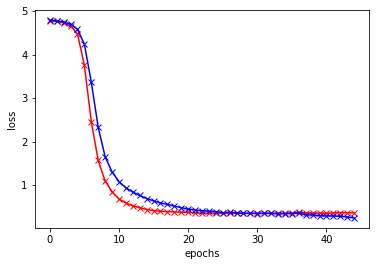

In [24]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

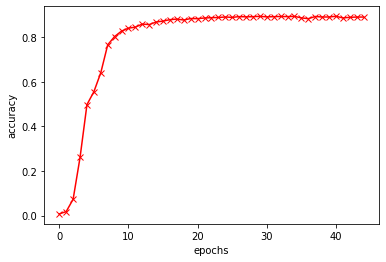

In [25]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

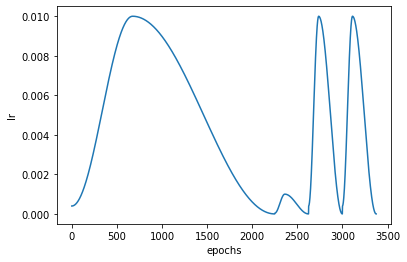

In [26]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

In [27]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

In [28]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in train_set.classes:
    breeds.append(rename(n))

Actual : American Staffordshire terrier  | Predicted : Weimaraner


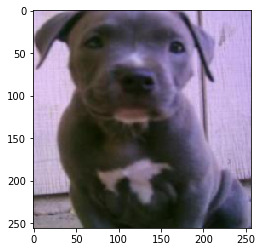

In [29]:
predict_single(*test_dataset[2427])

In [30]:
test_dl = DeviceDataLoader(test_loader, device)

In [31]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.3334149718284607, 'val_acc': 0.897417426109314}

In [33]:
torch.save(model, './models/dataloader-2_EfficV2_Acc90.pt')

In [34]:
torch.save(model.state_dict(), './models/dataloader-2_EfficV2_Acc90.pt')